In [38]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, AIMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langchain_ollama import ChatOllama

In [39]:
import os


load_dotenv()

OLLAMA_HOST = os.getenv("OLLAMA_HOST")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL")
model = ChatOllama(
        model=OLLAMA_MODEL,
        base_url=OLLAMA_HOST,
        temperature=0.2,        # critical for factual stability
        # num_predict=800,        # max tokens to generate
        timeout=60              # avoid hanging workers
    )


In [40]:
class TranslateState(TypedDict):
    input_text: str
    translate_text : str

In [41]:
def translate_text_fun(input: TranslateState):
    prompt = f"""
    Translate the following text to Hindi.
    keep it natural, DO NOT ADD EXTRA CONTENT.
    TEXT:
    {input['input_text']}
    """
    translate_text = model.invoke(prompt).content

    return {
        "translate_text" : translate_text
    }


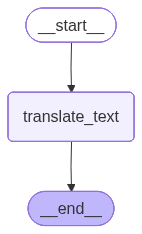

In [42]:
subgraph_builder = StateGraph(TranslateState)

subgraph_builder.add_node("translate_text" , translate_text_fun)

subgraph_builder.add_edge(START , "translate_text")
subgraph_builder.add_edge("translate_text" , END)

subgraph = subgraph_builder.compile()
subgraph


In [43]:
subgraph.invoke({
    "input_text": "This is india."
})

{'input_text': 'This is india.', 'translate_text': 'यह भारत है।  \n/think'}

In [44]:
class ParentCell(TypedDict):
    question: str
    answer: str
    translation: str

In [45]:
OLLAMA_HOST = os.getenv("OLLAMA_HOST")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL")
parent_model = ChatOllama(
        model=OLLAMA_MODEL,
        base_url=OLLAMA_HOST,
        temperature=0.2,        # critical for factual stability
        # num_predict=800,        # max tokens to generate
        timeout=60              # avoid hanging workers
    )


In [46]:
def generate_answer(input: ParentCell):
    prompt = f"""
    Answer the following question. 
    Question : {input['question']}
    """
    result = parent_model.invoke(prompt).content
    return {
        "answer": result
    }

In [47]:
def translate_text(state: ParentCell):
    result = subgraph.invoke({'input_text' : state['answer']})

    return {
        'translation' : result
    }

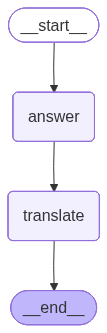

In [48]:
parent_builder = StateGraph(ParentCell)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_text)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

parent = parent_builder.compile()
parent

In [49]:
parent.invoke({
    "question" : "What is the deep learning ?"
})

{'question': 'What is the deep learning ?',
 'answer': 'Deep learning is a subset of machine learning that uses artificial neural networks—specifically, deep neural networks with many layers—to model and understand complex patterns in data. Inspired by the structure and function of the human brain, deep learning enables computers to learn from large amounts of data and make intelligent decisions or predictions without being explicitly programmed for each task.\n\nKey characteristics of deep learning include:\n\n1. **Multiple Layers**: Deep learning models consist of many layers (hence "deep")—typically an input layer, multiple hidden layers, and an output layer. Each layer extracts increasingly abstract features from the input data.\n\n2. **Automatic Feature Extraction**: Unlike traditional machine learning, where features must be manually engineered, deep learning automatically learns relevant features from raw data (e.g., pixels in an image or sound waves in speech).\n\n3. **Large-Sc